# Logrank with Imprint


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [2]:
# C++ code:
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/simple_log_rank.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/python/example/simple_log_rank.py
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/common/fixed_n_log_hazard_rate.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/stat/log_rank_test.hpp

In [3]:
# https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.multivariate_logrank_test
# https://en.wikipedia.org/wiki/Logrank_test
# https://web.stanford.edu/~lutian/coursepdf/unitweek3.pdf
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n0 = jnp.array([jnp.sum(~group), jnp.sum(group)])
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n0[:, None] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)


In [4]:
import scipy.stats
import lifelines
from lifelines.statistics import multivariate_logrank_test

rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)
ours = logrank_test(all_rvs, group, censoring_time=10000)
theirs = multivariate_logrank_test(all_rvs, group, t0=10000).test_statistic
ours**2, theirs

(DeviceArray(1.0942874, dtype=float32), 1.0942869668475728)

In [65]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = -theta[:, 0]
        treatment_hazard = -theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        control_rvs = jnp.tile(self.samples[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = self.samples[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        test_stat = -self.vmap_logrank_test(
            all_rvs, self.group, self.censoring_time
        )
        return test_stat

In [66]:
g = ip.cartesian_grid([-1, -1], [-1, -1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675100815, n_bits=18, worker_bits=18) = [4431587044590092288, ...]:


In [67]:
lr = LogRank(0, 200000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

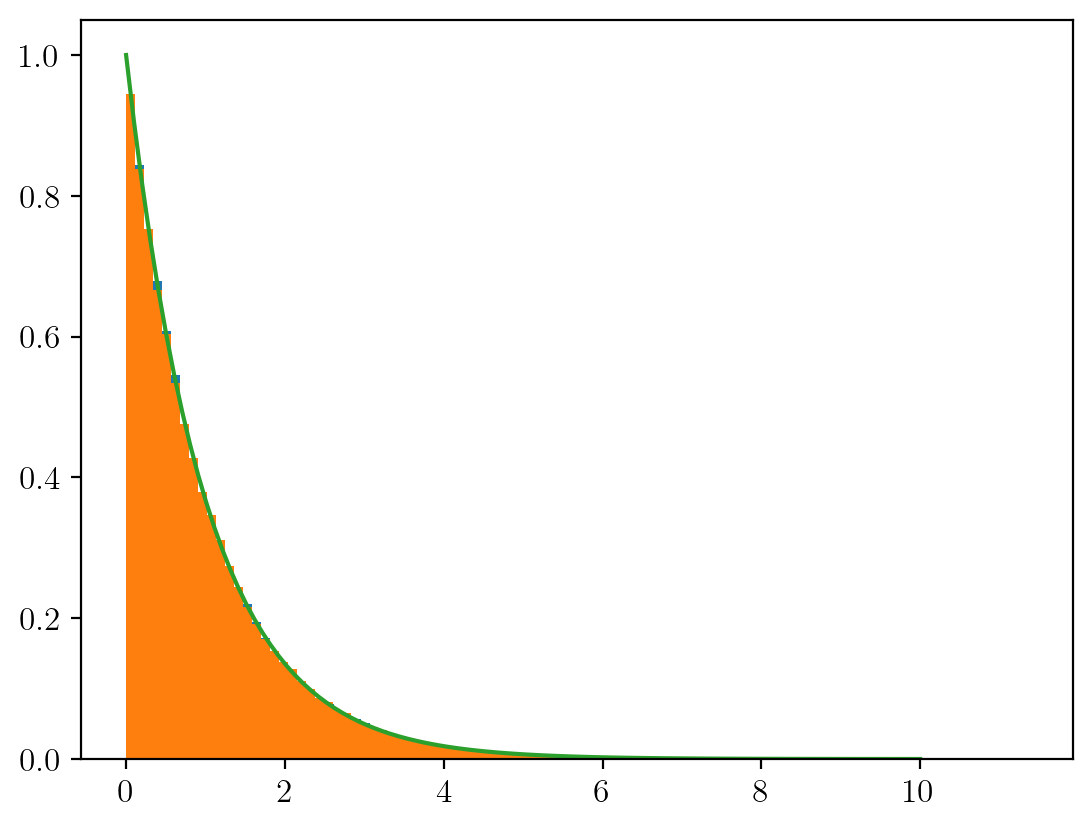

In [68]:
# plot lr.samples[:,0,0] and lr.samples[:,0,1] on the same plot
plt.figure()
plt.hist(lr.samples[:,0,0].ravel(), bins=100, density=True, label='control')
plt.hist(lr.samples[:,0,1].ravel(), bins=100, density=True, label='treatment')
# and compare to an exponential distribution with lambda = 1
x = jnp.linspace(0, 10, 100)
plt.plot(x, scipy.stats.expon.pdf(x), label="exponential")

plt.show()

The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

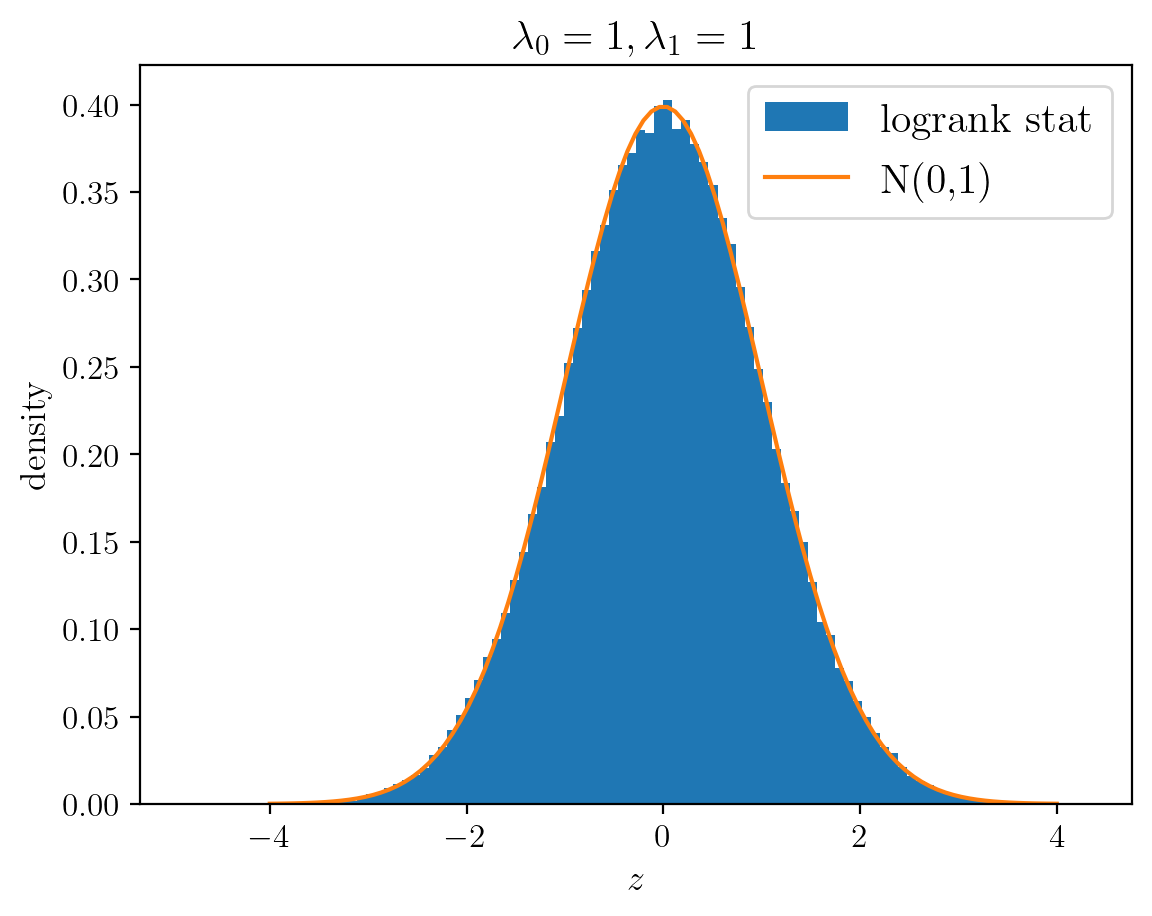

In [69]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), bins=100, density=True, label='logrank stat')
xs = np.linspace(-4, 4, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [70]:
g = ip.cartesian_grid([-2, -2], [-0.5, -0.5], n=[20, 20], null_hypos=[ip.hypo("theta0 > theta1")])
rej_df = ip.validate(LogRank, g=g, lam=-1.96, model_kwargs=dict(n=10, censoring_time=12))
rej_df

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1675100828, n_bits=18, worker_bits=18) = [4431587937943289856 4431587937943289857 4431587937943289858, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1675100829, n_bits=18, worker_bits=18) = [4431588006662766592 4431588006662766593 4431588006662766594, ...]:


,tie_sum,tie_est,tie_cp_bound,tie_bound
0,513,0.031311,0.034622,0.045023
1,439,0.026794,0.029876,0.039328
2,368,0.022461,0.025302,0.033773
3,318,0.019409,0.022066,0.029853
4,270,0.016479,0.018944,0.026026
...,...,...,...,...
214,513,0.031311,0.034622,0.063310
215,513,0.031311,0.034622,0.067028
216,513,0.031311,0.034622,0.071811
217,513,0.031311,0.034622,0.078174


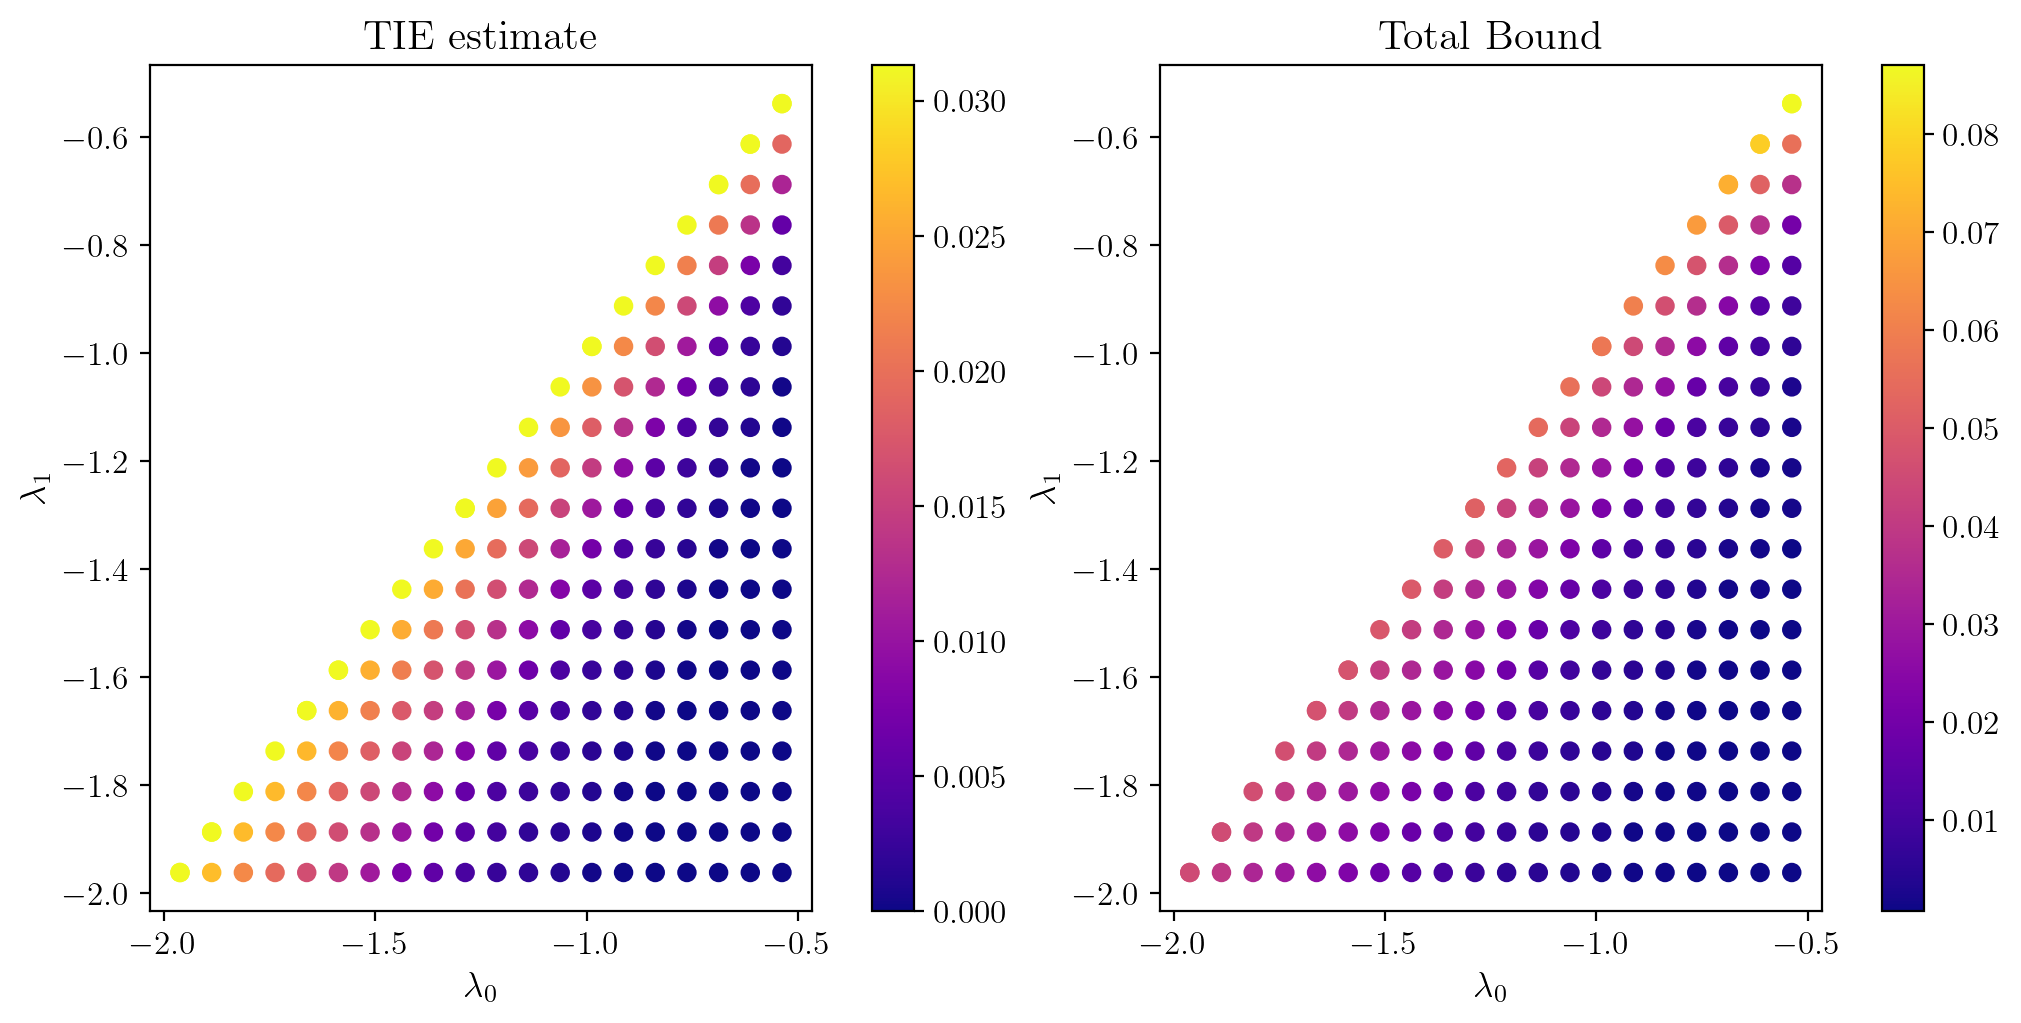

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(1,2,1)
plt.title('TIE estimate')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total Bound')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_bound'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.show()